## Urban Simulation Networks 3

# Open Street Map Road Networks

In [1]:
%matplotlib inline
import os
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# The python package geopadas is an extension of the data analysis library pandas for working with geographic data.
# It is dependent on a lot of other packages to run, so could take a while to install if the dependencies are not
# already installed.
import geopandas as gpd

In [2]:
spatial_data_dir = "..\\data\\Central_London_Shapefile\\shape"
road_shapefile = os.path.join(spatial_data_dir, "roadsExplodedBNG.shp")

In [3]:
gdf_roads = gpd.read_file(road_shapefile)

In [4]:
gdf_roads.crs = {'init' :'epsg:4326'}

# Geo dataframe of linestring geoetries representing roads
gdf_roads.head()

,osm_id,name,ref,type,oneway,bridge,maxspeed,WKT,LENGTH,geometry
0,31030,Grafton Way,A400,trunk,1,0,20.0,None,187.369101,LINESTRING (529483.8143688129 182281.611329109...
1,31039,Tottenham Court Road,A400,primary,1,0,30.0,None,79.939857,LINESTRING (529823.3187080636 181382.281772700...
2,31959,Cleveland Street,None,tertiary,1,0,30.0,None,84.214560,LINESTRING (529204.4352785718 181858.334078438...
3,2190803,Aldwych,A4,primary,1,0,30.0,None,209.367879,LINESTRING (530611.3123231975 180841.654082292...
4,2191122,Euston Road,A501,trunk,1,0,30.0,None,55.704402,LINESTRING (528840.0477737525 182211.829698606...


In [5]:
# How many records?
print(gdf_roads.shape)

# Check the geometry types - all Linestrings
print(gdf_roads['geometry'].map(lambda x: x.type).value_counts())

(3582, 10)
LineString    3582
Name: geometry, dtype: int64


In [6]:
# Access a single linestring geometry
line_graftton_way = gdf_roads.loc[0, "geometry"]

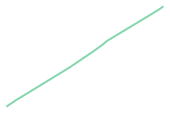

In [7]:
line_graftton_way

In [8]:
print("Linestring length: {}".format(line_graftton_way.length))

# How many coordinates make up this linestring
print("Number of coordinates: {}".format(len(line_graftton_way.coords)))

Linestring length: 187.36910057251944
Number of coordinates: 9


In [9]:
# In R a SpatialPolygonDataFrame object must be converted to a dataframe object using 
# the tidy function. Here we only work with the data as a geopandas geodatafram
# so this conversion isn't needed

# But we do need to extract the data we need to create a network from the 
# geodataframe

In [10]:
# Each linestring is made up of multiple coordinates, for example:
list(line_graftton_way.coords)

[(529483.814368813, 182281.6113291093),
 (529479.0436674849, 182278.15150009602),
 (529427.0891960037, 182246.78345147427),
 (529423.0121066675, 182243.34135236288),
 (529413.4705441933, 182236.4218160609),
 (529389.5881977602, 182220.2350710464),
 (529338.3262862903, 182188.8856223093),
 (529336.2735316479, 182187.7206165839),
 (529326.038057389, 182180.78358540888)]

In [11]:
line_graftton_way.xy

(array('d', [529483.814368813, 529479.0436674849, 529427.0891960037, 529423.0121066675, 529413.4705441933, 529389.5881977602, 529338.3262862903, 529336.2735316479, 529326.038057389]),
 array('d', [182281.6113291093, 182278.15150009602, 182246.78345147427, 182243.34135236288, 182236.4218160609, 182220.2350710464, 182188.8856223093, 182187.7206165839, 182180.78358540888]))

In [12]:
# To create the network, we must create a dataframe of all the coordinates
df_road_coords = pd.DataFrame(columns = ["x", "y", "id"])

In [13]:
# Loop through the linestring and for each one add their coords to the new 
# dataframe
for row_id, row in gdf_roads.iterrows():
    xy = row['geometry'].xy
    df = pd.DataFrame({"x": xy[0], "y":xy[1], "id":row_id})
    df_road_coords = pd.concat([df_road_coords, df], join='inner')
    
# Reinstace the index
df_road_coords.index = np.arange(len(df_road_coords))

In [14]:
df_road_coords.head()

,x,y,id
0,529483.814369,182281.611329,0
1,529479.043667,182278.151500,0
2,529427.089196,182246.783451,0
3,529423.012107,182243.341352,0
4,529413.470544,182236.421816,0


In [15]:
# The coordinates are in order so the second row coordinate connects to the first
# Create a second dataframe with the coordinates shifted down one and join with
# the original dataframe
df_road_coords.rename(columns={'x':'x1','y':'y1'}, inplace=True)
dfB = df_road_coords[1:].rename(columns={'y1':'y2','x1':'x2'})

first_row = df_road_coords.loc[0].rename({'y1':'y2','x1':'x2'})
dfB = dfB.append(first_row, ignore_index=True)

assert len(df_road_coords) == len(dfB)

In [16]:
df_road_coords = pd.merge(df_road_coords, dfB, left_index=True, right_index=True, how='outer', indicator=True)

C:\Anaconda3\lib\site-packages\pandas\core\computation\check.py:19: UserWarning: The installed version of numexpr 2.6.0 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [17]:
# Check that all rows merged correctly - all good
df_road_coords.loc[ df_road_coords['_merge'] != 'both']

,x1,y1,id_x,x2,y2,id_y,_merge


In [18]:
df_road_coords.head(10)

,x1,y1,id_x,x2,y2,id_y,_merge
0,529483.814369,182281.611329,0,529479.043667,182278.151500,0,both
1,529479.043667,182278.151500,0,529427.089196,182246.783451,0,both
2,529427.089196,182246.783451,0,529423.012107,182243.341352,0,both
3,529423.012107,182243.341352,0,529413.470544,182236.421816,0,both
4,529413.470544,182236.421816,0,529389.588198,182220.235071,0,both
5,529389.588198,182220.235071,0,529338.326286,182188.885622,0,both
6,529338.326286,182188.885622,0,529336.273532,182187.720617,0,both
7,529336.273532,182187.720617,0,529326.038057,182180.783585,0,both
8,529326.038057,182180.783585,0,529823.318708,181382.281773,1,both
9,529823.318708,181382.281773,1,529822.454421,181388.936123,1,both


In [19]:
df_road_coords.tail(10)

,x1,y1,id_x,x2,y2,id_y,_merge
16021,529672.940225,182187.402384,3579,529691.414341,182197.888702,3579,both
16022,529691.414341,182197.888702,3579,529691.414341,182197.888702,3580,both
16023,529691.414341,182197.888702,3580,529686.189419,182212.220910,3580,both
16024,529686.189419,182212.220910,3580,529691.596953,182217.922675,3580,both
16025,529691.596953,182217.922675,3580,529656.442483,182262.647502,3581,both
16026,529656.442483,182262.647502,3581,529684.432952,182226.641677,3581,both
16027,529684.432952,182226.641677,3581,529691.596953,182217.922675,3581,both
16028,529691.596953,182217.922675,3581,529697.345208,182210.280273,3581,both
16029,529697.345208,182210.280273,3581,529706.010216,182197.148659,3581,both
16030,529706.010216,182197.148659,3581,529483.814369,182281.611329,0,both


In [20]:
# Drop rows where IDs don't match
# This breaks the connection between different lines that don't share the 
# same coordinates. For lines that contain the same coordinates the start and
# end nodes will join up
df_road_coords = df_road_coords.loc[ df_road_coords['id_x'] == df_road_coords['id_y']]

In [21]:
# Drop unwanted columns
df_road_coords.drop(['id_x','id_y', '_merge'], axis=1, inplace=True)

In [22]:
# Get all points in a long dataframe and use to assign an ID to each coord
points1 = df_road_coords.reindex(columns = ['x1', 'y1']).rename(columns = {'x1':'x', 'y1':'y'})
points2 = df_road_coords.reindex(columns = ['x2', 'y2']).rename(columns = {'x2':'x', 'y2':'y'})
points = pd.concat([points1, points2]).drop_duplicates()
points['id'] = np.arange(len(points))

In [23]:
# Now join to the road coords dataframe to get the id of the start and end node
df_road_coords = pd.merge(df_road_coords, points, left_on = ['x1','y1'], right_on = ['x','y'], how='left')
df_road_coords = pd.merge(df_road_coords, points, left_on = ['x2','y2'], right_on = ['x','y'], how='left')

In [24]:
df_road_coords.head()

,x1,y1,x2,y2,x_x,y_x,id_x,x_y,y_y,id_y
0,529483.814369,182281.611329,529479.043667,182278.151500,529483.814369,182281.611329,0,529479.043667,182278.151500,1
1,529479.043667,182278.151500,529427.089196,182246.783451,529479.043667,182278.151500,1,529427.089196,182246.783451,2
2,529427.089196,182246.783451,529423.012107,182243.341352,529427.089196,182246.783451,2,529423.012107,182243.341352,3
3,529423.012107,182243.341352,529413.470544,182236.421816,529423.012107,182243.341352,3,529413.470544,182236.421816,4
4,529413.470544,182236.421816,529389.588198,182220.235071,529413.470544,182236.421816,4,529389.588198,182220.235071,5


In [25]:
# Tidy up
df_road_coords = df_road_coords.reindex(columns = ['x1','y1','x2','y2','id_x','id_y'])
df_road_coords.rename(columns = {'id_x':'id_start','id_y':'id_end'}, inplace=True)

In [26]:
# Calculate the distance
df_road_coords['distance'] = np.sqrt(np.square(df_road_coords['x1'] - df_road_coords['x2']) + np.square(df_road_coords['y1'] - df_road_coords['y2']))

In [27]:
df_road_coords.head()

,x1,y1,x2,y2,id_start,id_end,distance
0,529483.814369,182281.611329,529479.043667,182278.151500,0,1,5.893217
1,529479.043667,182278.151500,529427.089196,182246.783451,1,2,60.689551
2,529427.089196,182246.783451,529423.012107,182243.341352,2,3,5.335795
3,529423.012107,182243.341352,529413.470544,182236.421816,3,4,11.786492
4,529413.470544,182236.421816,529389.588198,182220.235071,4,5,28.850948


In [28]:
# Drop the coordinate columns, these are no longer needed
df_network = df_road_coords.reindex(columns = ['id_start','id_end','distance'])

In [29]:
# Save this
df_network.to_csv(os.path.join("..\\data\\central_london_road_network.csv"), index=False)

In [32]:
# Create a graphy using the dataframe
graph_roads = nx.from_pandas_edgelist(df_network, source='id_start',target='id_end',edge_attr='distance')

In [33]:
len(graph_roads.edges())

12334

In [34]:
# Is the graph connected?
print(nx.is_connected(graph_roads))

# Can also check if weakly connected / strongly conneted for directed graphs using is_weakly_connected(), is_strongly_connected()

False


In [35]:
# Number of connected components
nx.number_connected_components(graph_roads)

55

In [36]:
# Select the largest connected component

# Using max with key=len selects the largest connected component subgraphs from the generator of connected components
largest_component = max(nx.connected_component_subgraphs(graph_roads), key = len)
largest_component.size()

11944

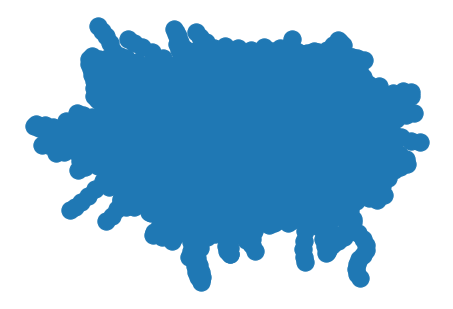

In [37]:
# plot it - doesn't look great
nx.draw(largest_component)

In [38]:
# Using the geographical coordinates of the nodes when plotting them
points_pos = points.set_index('id')
points_pos['pos'] = list(zip(points_pos['x'], points_pos['y']))

# Get dictionary of node id to (lat:lon)
geo_pos = points_pos['pos'].to_dict()

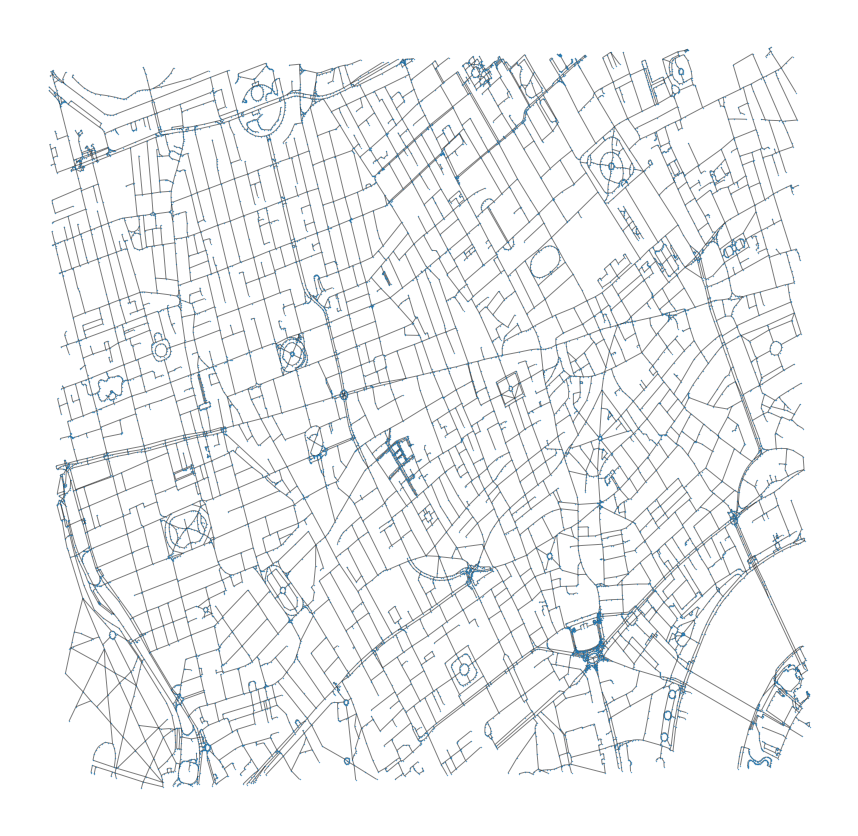

In [39]:
# Plot using geographic coordinates and more settings
plt.figure(figsize = (15,15))
nx.draw_networkx_nodes(largest_component, geo_pos, nodelist=largest_component.nodes(), node_size = 0.1)
nx.draw_networkx_edges(largest_component, geo_pos, width = 1, color = 'grey', alpha=0.5)
plt.axis('off')
plt.show()